### Satellite and gauge data at Kīlauea ###


#### Supplementary to Farquharson and Amelung (2020), doi: [10.1038/s41586-020-2172-5](https://doi.org/10.1038/s41586-020-2172-5)

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines
import matplotlib.transforms as transforms
import matplotlib
from matplotlib.ticker import LogFormatterExponent
matplotlib.rc('text', usetex = True)
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import ConnectionPatch, Polygon
import datetime as dt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os

from datetime import datetime, timedelta
import datetime as dt

from netCDF4 import Dataset
import string as STRING
import pandas as pd
print("All packages imported")

All packages imported


In [27]:
'''
Function converts mm input to inches (for plotting figures the correct size).
'''

def mm2inch(*tupl):
    if isinstance(tupl[0], tuple):
        return tuple(k*0.0393701 for k in tupl[0])
    else:
        return tuple(k*0.0393701 for k in tupl)
    
'''
For formatting logarithmic axis labels
'''
class LogFormatterTexTextMode(LogFormatterExponent):
    def __call__(self, x, pos=None):
        x = LogFormatterExponent.__call__(self, x,pos)
        s = r"10\textsuperscript{{{}}}".format(x)
        return s

In [15]:
'''
filepath will point to current location of the Jupyter Notebook.
Creates a folder for downloading data into, and another for figures.
'''
import os
from os import path
os.getcwd()
!pwd
if not os.path.exists('data'):
    os.mkdir('data')
else:
    print("'data' directory already exists'")
if not os.path.exists('figures'):
    os.mkdir('figures')
else:
    print("'figures' directory already exists'")

filepath = os.getcwd()

/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk
'data' directory already exists'
'figures' directory already exists'


In [18]:
'''
Generate 'data_url.txt' file with list of urls required for data download. The default is to download all data from 01 Mar 2000 up until yesterday. 
A window of dates can be entered instead, for example: 

data_range(first=dt.date(2018, 12, 15), last=dt.date(2018,12,18))

'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data

prefix = 'https://disc2.gesdisc.eosdis.nasa.gov/data/TRMM_RT/TRMM_3B42RT_Daily.7/'

suffix = '.7.nc4\n'

yesterday = dt.date.today() - timedelta(1)

start_date = dt.date(2000, 3, 1)
end_date = dt.date(2019, 12, 31)

def data_range_string(first = None, last = end_date):
    data_dates = last - first
    for j in range(data_dates.days + 1):
        yield (first + timedelta(days = j)).strftime('%Y/%m')+'/3B42RT_Daily.'+(first + timedelta(days = j)).strftime('%Y%m%d')


string_list = list(data_range_string(first = start_date))#, last=dt.date(2018,12,18)))

with open("data_url.txt", "w") as output:
    for line in list([ prefix+x+suffix for x in string_list ]):
        output.write(str(line))

#### The TRMM/GPM satellite data is made freely available through NASA's GES Disc Portal. ####
Citation:

In [19]:
print("Tropical Rainfall Measuring Mission (TRMM) (2011),\nTRMM (TMPA) Rainfall Estimate L3 3 hour 0.25 degree x 0.25 degree V7, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: {},\ndoi: 10.5067/TRMM/TMPA/3H/7".format(dt.date.today()))

Tropical Rainfall Measuring Mission (TRMM) (2011),
TRMM (TMPA) Rainfall Estimate L3 3 hour 0.25 degree x 0.25 degree V7, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: 2020-07-15,
doi: 10.5067/TRMM/TMPA/3H/7


In [20]:
'''
Access and download data files specified in data_url using wget. Will skip previously downloaded files.

Note: despite -nv, will be verbose if large number of new datafiles are being accessed. 
Right-click on cell and Enable Scrolling for Outputs, if necessary.
One can change -nv to -q, but it may be useful to have some output. 
Can take a long time if none of the data have been retrieved before,
especially if a long time-series is being examined.
'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data
!wget -nv -i data_url.txt -nc -c 
print('Data retrieved')

Data retrieved


In [21]:
'''
Opens textfile with list of data urls.
Removes useless characters and returns a list of filenames for later use, as well as a list of dates. 
'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data
datafile = 'data_url.txt'
f = open(datafile)
f.seek(0)
fileIDs = f.readlines()
f.close()
fileIDs = [line.rstrip('\n') for line in fileIDs]
fileIDs = [line.lstrip(prefix) for line in fileIDs]
file_list =[]
for j,k in enumerate(fileIDs):
    text = fileIDs[j]
    if text.endswith('nc4'):    # Only deals with files that are netcdf format
        file_list.append(fileIDs[j][7:])
    else:
        continue
file_names = []
for j,k in enumerate(file_list):
    file_names.append(file_list[j][13:21])
fd =[]
for j,k in enumerate(file_names):
    fd.append(file_names[j][0:4]+'-'+file_names[j][4:6]+'-'+file_names[j][6:])
file_dates = [dt.datetime.strptime(k, '%Y-%m-%d').date() for k in fd]
print("Dates available : {} to {}".format(file_dates[0], file_dates[-1]))

Dates available : 2000-03-01 to 2019-12-31


In [24]:
'''
Open netcdf files and extract information. Can take up to around 5 minutes.
'''

if os.getcwd() != filepath+'/data':
    %cd $filepath/data
    
ncFid = Dataset(file_list[0],"r", format = "NETCDF4") # Open just the first file to extract latitude and longitude data
longitude = ncFid.variables['lon'][:]
latitude = ncFid.variables['lat'][:]
ncFid.close() # Close file once done

precipitation = [] # Create precipitation variable
start_dates = [] # Create date variable
m = -1
for j,k in enumerate(file_list): # Interrogates file_list as defined above
    ncFid = Dataset(file_list[j],"r", format = "NETCDF4")
    precipitation.append(np.transpose(ncFid.variables['precipitation'][:])) # Iteratively append precipitation data
    start_dates.append(np.transpose(ncFid.BeginDate)) # Iteratively append date information
    ncFid.close() # Close file before opening next
    if j % int(np.ceil(len(file_list)/100)) == 0:
        m += 1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
file_dates = file_dates[0:len(precipitation)]
print("{} dates".format(len(precipitation)))

01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  7245 dates


In [28]:
'''
Data are not infinite, so these lambda functions determine the latitude and longitute in the NCDF4 file(s) that
are closest to the precise coordinates of a given volcano. 
'''
name_volc = 'Kilauea'
lat_volc = 19.4069
lon_volc = -155.2834

j_volc = min(longitude, key=lambda x:abs(x-lon_volc))
i_volc = min(latitude, key=lambda x:abs(x-lat_volc))

In [38]:
'''
Extract satellite rainfall data for summit region and adjacent grid cells
'''

ki_rainfall_1 = []
ki_rainfall_2 = []
ki_rainfall_3 = []
ki_rainfall_4 = []
ki_rainfall_5 = []
for j,k in enumerate(precipitation):
    ki_rainfall_1.append(precipitation[j][list(
        latitude).index(i_volc)][list(longitude).index(j_volc)]) 
    ki_rainfall_2.append(precipitation[j][list(
        latitude).index(i_volc)][list(longitude).index(j_volc+.5)])
    ki_rainfall_3.append(precipitation[j][list(
        latitude).index(i_volc)][list(longitude).index(j_volc+.25)])
    ki_rainfall_4.append(precipitation[j][list(
        latitude).index(i_volc+.25)][list(longitude).index(j_volc+.5)])
    ki_rainfall_5.append(precipitation[j][list(
        latitude).index(i_volc+.25)][list(longitude).index(j_volc+.25)])

In [39]:
'''
Satellite rainfall data added to dictionary of dataframes
'''
ki_rainfall_1_df = pd.DataFrame({"PRCP": ki_rainfall_1})
ki_rainfall_2_df = pd.DataFrame({"PRCP": ki_rainfall_2})
ki_rainfall_3_df = pd.DataFrame({"PRCP": ki_rainfall_3})
ki_rainfall_4_df = pd.DataFrame({"PRCP": ki_rainfall_4})
ki_rainfall_5_df = pd.DataFrame({"PRCP": ki_rainfall_5})

for df in [ki_rainfall_1_df, ki_rainfall_2_df, ki_rainfall_3_df, ki_rainfall_4_df, ki_rainfall_5_df]:
    df["roll30"] = df.PRCP.rolling(30).sum() ## 30-day rolling sum
    df["roll180"] = df.PRCP.rolling(180).sum() ## 180-day rolling sum
    df["log30"] = np.log(df.roll30) ## logarithm of 30-day sum
    df["log180"] = np.log(df.roll180) ## logarithm of 180-day sum

In [32]:
'''
Read in NCDC gauge data (accesses the GitHub project where we have uploaded the gauge data)
'''
all_gauges = pd.read_csv("https://raw.githubusercontent.com/jifarquharson/Farquharson_Amelung_2020_Kilauea-Nature/master/gauge_data/all_gauges_.csv")
all_gauges.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,MDPR,PRCP,SNOW,SNWD
0,USC00517023,"KEAAU 92, HI US",19.63333,-155.03333,85.0,1930-01-01,NaN,NaN,0.0,NaN,NaN
1,USC00517023,"KEAAU 92, HI US",19.63333,-155.03333,85.0,1930-01-02,NaN,NaN,3.0,NaN,NaN
2,USC00517023,"KEAAU 92, HI US",19.63333,-155.03333,85.0,1930-01-03,NaN,NaN,5.8,NaN,NaN
3,USC00517023,"KEAAU 92, HI US",19.63333,-155.03333,85.0,1930-01-04,NaN,NaN,2.3,NaN,NaN
4,USC00517023,"KEAAU 92, HI US",19.63333,-155.03333,85.0,1930-01-05,NaN,NaN,0.0,NaN,NaN


In [33]:
'''
One of the gauges is in a separate file. Read it in and add to the dataframe.
'''
keaau_2 = pd.read_csv("https://raw.githubusercontent.com/jifarquharson/Farquharson_Amelung_2020_Kilauea-Nature/master/gauge_data/keaau_2.csv")
all_gauges = all_gauges.append(keaau_2)

In [34]:
datetimes = []
for j in all_gauges.DATE:
    datetimes.append(dt.datetime.strptime(j, "%Y-%m-%d"))
all_gauges['dates'] = datetimes

gauge_list = [name for name in list(set(all_gauges.NAME))]
stn_list = [stn for stn in list(set(all_gauges.STATION))]
print("List of stations covered: {}".format(stn_list))

List of stations covered: ['US1HIHI0008', 'USC00516552', 'USC00517457', 'US1HIHI0003', 'USC00513872', 'US1HIHI0060', 'US1HIHI0051', 'USC00517023', 'USW00021504', 'US1HIHI0055', 'USC00511303']


In [35]:
'''
Separate gauges into individual dataframes based on name or number
'''

kuristown = all_gauges[all_gauges.NAME == 'KURTISTOWN 6.6 SSE, HI US']
pahoa_1 = all_gauges[all_gauges.NAME == 'PAHOA 7.5 S, HI US']
pahoa_2 = all_gauges[all_gauges.NAME == 'PAHOA 2.7 SSE, HI US']
pahoa_3 = all_gauges[all_gauges.NAME == 'PAHOA 2.1 E, HI US']
pahoa_4 = all_gauges[all_gauges.NAME == 'PAHOA 65, HI US']
hilo = all_gauges[all_gauges.NAME == 'HILO INTERNATIONAL AIRPORT 87, HI US']
keaau_1 = all_gauges[all_gauges.STATION == 'USC00517023']
keaau_2 = all_gauges[all_gauges.STATION == 'USC00513872']
mt_view_1 = all_gauges[all_gauges.NAME == 'MOUNTAIN VIEW 4.5 NNE, HI US']
mt_view_2 = all_gauges[all_gauges.NAME == 'MOUNTAIN VIEW 91, HI US']
hvnp_1 = all_gauges[all_gauges.NAME == 'HAWAII VOL. NATIONAL PARK HQ. 54, HI US']

In [49]:
'''
List of all dataframes for iteration
'''
df_list = [kuristown, pahoa_1, pahoa_2, pahoa_3, pahoa_4, hilo, keaau_1,keaau_2, mt_view_1, mt_view_2, hvnp_1]

'''
Calculate cumulative data for each dataframe
'''
for df in df_list:
    df["roll30"] = df.PRCP.fillna(0).rolling(30).sum()
    df["roll90"] = df.PRCP.fillna(0).rolling(90).sum()
    df["roll180"] = df.PRCP.fillna(0).rolling(180).sum()
    df["log30"] = np.log(df.roll30)
    df["log90"] = np.log(df.roll90)
    df["log180"] = np.log(df.roll180)
    try:
        print("{} most recent date: {}".format(df.STATION.values[0], max(df.DATE)))
    except:
        print("null")

US1HIHI0055 most recent date: 2018-06-01
US1HIHI0008 most recent date: 2018-04-28
US1HIHI0051 most recent date: 2018-06-01
US1HIHI0003 most recent date: 2018-06-01
USC00517457 most recent date: 2018-06-01
USW00021504 most recent date: 2018-06-01
USC00517023 most recent date: 1962-12-31
USC00513872 most recent date: 2018-05-31
US1HIHI0060 most recent date: 2018-06-01
USC00516552 most recent date: 2018-06-01
USC00511303 most recent date: 2015-06-22


#### The following cells define a series of notebook-specific functions for different figure panels or components thereof ####
They are neither efficient nor pretty.

In [41]:
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) ## set up logarithmic axis options
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=12)

In [5]:
def plot_marginal_histograms(axis, df):
    
    ax2 = axis.twiny()
    MIN, MAX = [x for x in axis.get_ylim()]
    ax2.hist(df.roll30, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50),
             orientation = "horizontal", density = False, clip_on=False, histtype="step", ec="dodgerblue", lw=1)
    num, edges, patches = ax2.hist(df.roll30, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50),
             orientation = "horizontal", density = False, clip_on=False)
    ax2.set_xlim(-1e4, -1e2)
    ax2.axis("off")
    a = df.log30[np.isfinite(df.log30)]
    std_1 = np.exp(np.nanmean(a)+(1*np.nanstd(a)))
    std_1_ = np.exp(np.nanmean(a)-(1*np.nanstd(a)))
    std_2 = np.exp(np.nanmean(a)+(2*np.nanstd(a)))
    std_2_ = np.exp(np.nanmean(a)-(2*np.nanstd(a)))
    centers = 0.5*(edges[:-1] + edges[1:])
    for patch, center in zip(patches, centers):
        if center > std_2 or center < std_2_:
            patch.set_facecolor("r")
        elif center > std_1 or center < std_1_:
            patch.set_facecolor("lightgrey")
        else:
            patch.set_facecolor("w")


In [4]:
def plot_marginal_histograms_122(axis, df):
    
    ax2 = axis.twiny()
    MIN, MAX = [x for x in axis.get_ylim()]
    
    data = df.PRCP.fillna(0).rolling(122).sum()
    log_data = [np.log(x) for x in data]
    ax2.hist(data, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50),
             orientation = "horizontal", density = False, clip_on=False, histtype="step", ec="k", lw=1)
    num, edges, patches = ax2.hist(data, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50),
             orientation = "horizontal", density = False, clip_on=False)
    ax2.set_xlim(-1e4, -2e2)

    a = log_data#df.log30[np.isfinite(df.log30)]
    std_1 = np.exp(np.nanmean(a)+(1*np.nanstd(a)))
    std_1_ = np.exp(np.nanmean(a)-(1*np.nanstd(a)))
    std_2 = np.exp(np.nanmean(a)+(2*np.nanstd(a)))
    std_2_ = np.exp(np.nanmean(a)-(2*np.nanstd(a)))
    centers = 0.5*(edges[:-1] + edges[1:])
    for patch, center in zip(patches, centers):
        if center > std_2 or center < std_2_:
            patch.set_facecolor("r")
        elif center > std_1 or center < std_1_:
            patch.set_facecolor("lightgrey")
        else:
            patch.set_facecolor("w")
    ax2.axis("off")
            

In [6]:
'''
Iterates through rainfall dataframes, plots rainfall timeseries (cumulative 30-day),
and highlights statistical outliers
'''
def plot_satellite_timeseries():
    for ix, df in enumerate([ki_rainfall_1_df, ki_rainfall_2_df, ki_rainfall_3_df, ki_rainfall_4_df, ki_rainfall_5_df]):
        i = ix
        a = df.log30[np.isfinite(df.log30)]
        axs[i].step(file_dates, df.roll30, color = "w",
                    lw = 1.5, zorder = 999)
        axs[i].step(file_dates, df.roll30, color = "dodgerblue",
                    lw = 0.8, zorder = 999)

        axs[i].set_yscale("log")

        axs[i].set_ylim(0.11, 900)
        axs[i].axhline(np.exp(np.nanmean(a)), color = 'k', lw = .8, zorder = 10)
        axs[i].yaxis.set_major_formatter(LogFormatterTexTextMode())
        axs[i].yaxis.set_major_locator(locmaj)
        axs[i].yaxis.set_minor_locator(locmin)
        axs[i].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        axs[i].yaxis.set_tick_params(labelsize=7)
        axs[i].set_xlim(min(file_dates), max(file_dates))
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
        axs[i].tick_params(axis='both', which='major', labelsize="xx-small", direction="out")
        
        plot_marginal_histograms(axs[i], df)

        if ix != 4:
            axs[i].set_xticks([])
            axs[i].spines["bottom"].set_visible(False)
            

        axs[i].fill_between(file_dates, where = (df.roll30 >= (np.exp(np.nanmean(a)+(1*np.nanstd(a))))),
                    y1=1e2, y2=2e3, facecolor = 'lightgrey' , label = 'on', )
        axs[i].fill_between(file_dates, where = (df.roll30 >= (np.exp(np.nanmean(a)+(2*np.nanstd(a))))),
                    y1=1e2, y2=2e3, facecolor = 'red' , label = 'on', )

        axs[i].annotate("{}".format(STRING.ascii_lowercase[ix]), xy = (0,1), xytext = (4,-4),
                        xycoords = 'axes fraction', textcoords='offset points',
                   fontsize = 8)

    marker_1 = plt.scatter([],[], marker = 's', s=5, color = "lightgrey", edgecolors="none",
                           linewidth = 0.5,)
    marker_2 = plt.scatter([],[], marker = 's', s=5, color = "red", edgecolors="none",linewidth = 0.5)

    legend = axs[0].legend([marker_1, marker_2],[r'Exceeds 1 $\varsigma$', r'Exceeds 2 $\varsigma$'],fontsize = "x-small", edgecolor = "None", fancybox="None",
                        markerscale = 1, handlelength = 0.7,ncol=2, loc='upper right', bbox_to_anchor=(1, 1.8),
                       framealpha=0)
    legend.get_frame().set_linewidth(0.8)

In [7]:
def plot_pahoa_rain(axis):
    ax = axis
    index = pahoa_3.dates
    series = pd.Series(pahoa_3.PRCP.fillna(0).values, index = index)
    pahoa_3_bin = series.resample('4m').sum()
    ax.bar(pahoa_3_bin.index, pahoa_3_bin, ec = "w", color = "grey", width = 1)
    ax.plot(pahoa_3.dates, pahoa_3.PRCP.fillna(0).rolling(122).sum(), zorder = 10, alpha= 1, color = "w", lw = 1.5)
    ax.plot(pahoa_3.dates, pahoa_3.PRCP.fillna(0).rolling(122).sum(), zorder = 10, alpha= 1, color = "k", lw = 0.8, ls="-.")
    ax.set_xlim(
        min(pahoa_3.dates), 
        max(pahoa_3.dates))

    a = np.log(pahoa_3.PRCP.fillna(0).rolling(30).sum())
    ax.plot(pahoa_3.dates, pahoa_3.PRCP.fillna(0).rolling(30).sum(), zorder = 10, alpha= 1, color = "w", lw = 1.5)
    ax.plot(pahoa_3.dates, pahoa_3.PRCP.fillna(0).rolling(30).sum(), zorder = 10, alpha= 1, color = "dodgerblue", lw = 0.8)
    ax.axhline(np.exp(np.nanmean(a)), color = "k", lw= 1)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(LogFormatterTexTextMode())
    ax.yaxis.set_major_locator(locmaj)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.yaxis.set_tick_params(labelsize=7)
    ax.tick_params(axis='both', which='major', labelsize="xx-small", direction="out")
    ax.set_xlim(xmin = "2010-08-01")
    plot_marginal_histograms_122(ax, pahoa_3)
    plot_marginal_histograms(ax, pahoa_3)
    


### Plot Figure ###

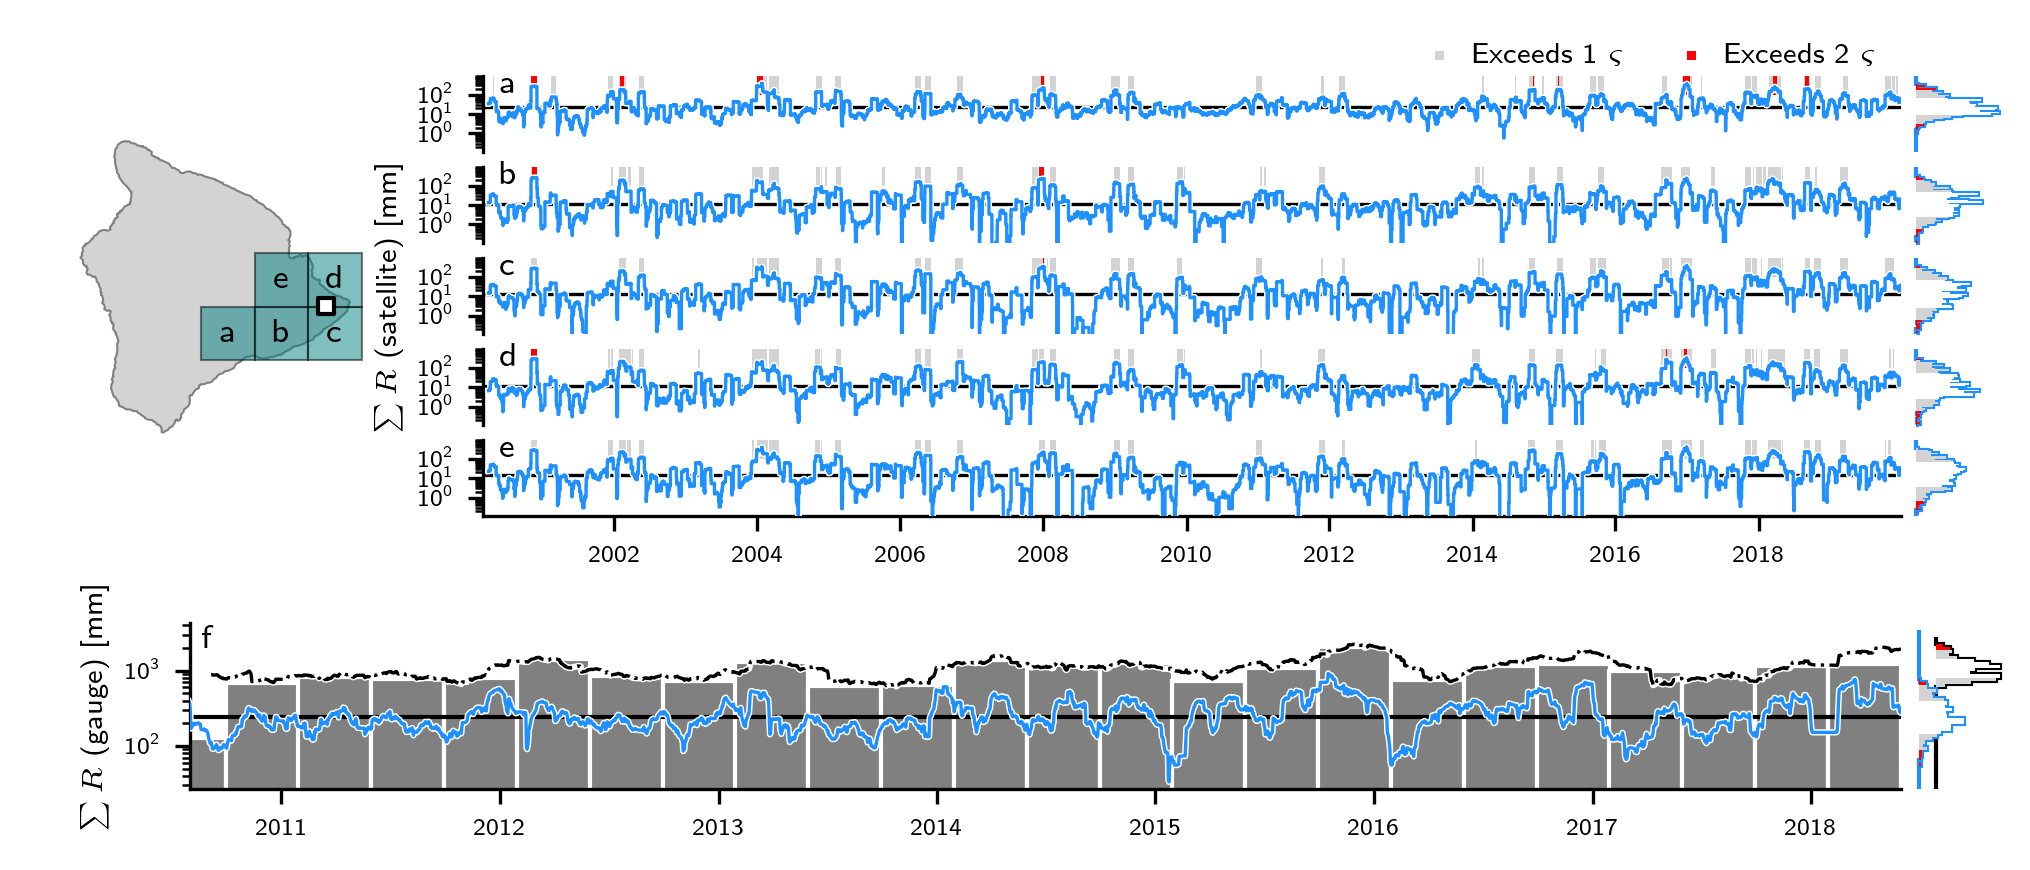

In [55]:
fig = plt.figure(figsize=mm2inch(187, 80), dpi = 300)

axs = [    plt.subplot2grid((8, 6), (0, 1), colspan = 5),
    plt.subplot2grid((8, 6), (1, 1), colspan = 5),
    plt.subplot2grid((8, 6), (2, 1), colspan = 5),
    plt.subplot2grid((8, 6), (3, 1), colspan = 5),
    plt.subplot2grid((8, 6), (4, 1), colspan = 5),
     plt.subplot2grid((8, 6), (6, 0), rowspan = 2, colspan = 6),
]


mapax_ = fig.add_axes([.05, 0.5, 0.18, 0.34])
m = Basemap(llcrnrlon=-156.3,
            llcrnrlat=18.9,
            urcrnrlon=-154.5,
            urcrnrlat=20.4,
            projection='cyl',
            resolution = 'h',
            area_thresh=110,
            ax=mapax_)
m.drawcoastlines(linewidth = .5, color = 'grey')

m.fillcontinents(color='lightgrey')

j = -155.2834 
i = 19.4069

j_offsets = [0,.25,.5,.5,.25]
i_offsets = [0,0,0,.25,.25]
for ix, val in enumerate(j_offsets):
    
    j_trmm = min(longitude, key=lambda x:abs(x-j))+val
    i_trmm = min(latitude, key=lambda x:abs(x-i))+i_offsets[ix]
    
    x1,y1 = (j_trmm+0.125,i_trmm-.125)
    x2,y2 = (j_trmm+0.125,i_trmm+0.125)
    x3,y3 = (j_trmm-.125,i_trmm+0.125)
    x4,y4 = (j_trmm-.125,i_trmm-.125)

    poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='teal',hatch = '',alpha = 0.5,
                   edgecolor="k", linestyle = "solid",linewidth=0.5,
                   zorder = 2)
    mapax_.annotate("{}".format(STRING.ascii_lowercase[ix]), xy = (j_trmm, i_trmm), xytext = (0,0), xycoords = 'data', textcoords='offset points',
               fontsize = 8, va = "center", ha = "center")
    mapax_.add_patch(poly)
mapax_.axis('off')
mapax_.scatter(pahoa_3.LONGITUDE.values[0], pahoa_3.LATITUDE.values[0],
           marker = "s", s = 16, ec = "k", color ="w", zorder = 1000)



plot_satellite_timeseries()

plot_pahoa_rain(axs[5])

# # new_ax = fig.add_axes([0.843,0.125,0.01,0.765])
# #     new_ax.set_facecolor("none")
# #     new_ax.set_xticks([])
# #     new_ax.set_yticks([])

axs[2].set_ylabel(r"$\sum R$ (satellite) [mm]", fontsize = "x-small")
axs[5].set_ylabel(r"$\sum R$ (gauge) [mm]", fontsize = "x-small")
axs[5].annotate("{}".format(STRING.ascii_lowercase[5],), xy = (0,1), xytext = (4,-4),
                xycoords = 'axes fraction', textcoords='offset points',
               fontsize = 8, va = "center", ha = "center")
plt.show()

#### Figure XX ####

__a__—**e** Uncalibrated 30-day cumulative rainfall data (ΣR) for different TRMM/GPM grid cells (see map). For each time-series, the mean is given as a solid horizontal line. Grey and red vertical bars indicate periods where ΣR exceeded 1 and 2 standard deviations (ς) of the mean, respectively. Note that in early 2018, in all cases the rainfall signal is significantly greater than the mean at either the 1 or 2ς level. Marginal plots show histograms of rainfall cumulative rainfall data, demonstrating the underlying lognormal distribution from which standard deviations are obtained. 

  __f__ Time-series obtained from gauge data for station US1HIHI0003 (white marker on map, Fig. 2c-bottom of Poland et al.). Grey bars (4-month binned data) and dashed black line allow comparison of discrete bins and contiguous cumulative data (the rolling 122-day sum). Blue line shows the 30-day ΣR, with solid black line representing the mean as in previous panels. Marginal plots show histogram of 30-day cumulative data (inner) and 122-day cumulative data (outer).
